#Edge Detection

**Goal:** Use the manual convolution function to compute Sobel-X and Sobel-Y, then compute:
- Gradient magnitude (edge strength)
- Gradient orientation (edge direction)
- A binary edge map using thresholding

Finally, compare the manual results with OpenCV’s cv2.Sobel (visual + MAE/MSE).

In [3]:
# Imports
import cv2
import numpy as np
from matplotlib import pyplot as plt

(np.float64(-0.5), np.float64(224.5), np.float64(224.5), np.float64(-0.5))

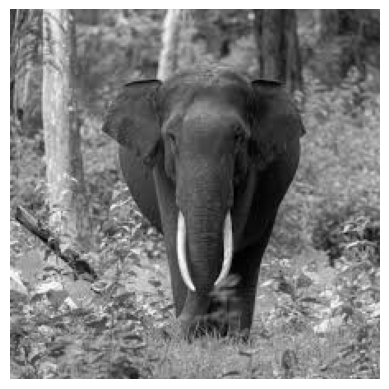

In [4]:
# Load image and convert to grayscale
# Note: All operations in this question are performed on the grayscale image.

img = cv2.imread('image.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(gray, cmap='gray')
plt.axis('off')

In [5]:
# Helper Functions
# - normalize_0_255: scale image to [0,255] for visualization (uint8)
# - show_row: show images side-by-side
# - MAE/MSE: numerical comparison between manual and OpenCV results


def normalize_0_255(img: np.ndarray) -> np.ndarray:
    img = img.astype(np.float32, copy=False)
    mn, mx = float(img.min()), float(img.max())
    if mx - mn < 1e-8:
        return np.zeros_like(img, dtype=np.uint8)
    img = (img - mn) / (mx - mn)
    return (255.0 * img).astype(np.uint8)

def show_row(images, titles, figsize=(16,5)):
    plt.figure(figsize=figsize)
    for i, im in enumerate(images):
        plt.subplot(1, len(images), i+1)
        plt.imshow(im, cmap="gray")
        plt.title(titles[i])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

def mae(a: np.ndarray, b: np.ndarray) -> float:
    a = a.astype(np.float32, copy=False)
    b = b.astype(np.float32, copy=False)
    return float(np.mean(np.abs(a - b)))

def mse(a: np.ndarray, b: np.ndarray) -> float:
    a = a.astype(np.float32, copy=False)
    b = b.astype(np.float32, copy=False)
    return float(np.mean((a - b) ** 2))


# 1. Manual Sobel (using manual convolution)
Apply Sobel-X and Sobel-Y using the manual convolution function.

Note: Sobel outputs can be negative, so we keep results in float32.
For visualization we display abs() and normalize to [0,255].

In [6]:
# Manual convolution (from Q1 style)
# - Explicit zero-padding
# - Supports arbitrary kernel sizes (even/odd)
# - Computation in float32
# Note: This implementation performs CORRELATION (kernel is not flipped).
# This matches common OpenCV filtering conventions and is sufficient here.

def manual_convolution(image: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    # Convert inputs to float to avoid overflow and allow negative values
    image = image.astype(np.float32, copy=False)
    kernel = kernel.astype(np.float32, copy=False)


    H, W = image.shape

    # Kernel dimensions
    Kh, Kw = kernel.shape

    # Define kernel anchor (center)
    # For even-sized kernels, integer division determines the anchor location
    anchor_y = Kh // 2
    anchor_x = Kw // 2

    # Padding sizes around the image
    pad_top = anchor_y
    pad_left = anchor_x
    pad_bottom = Kh - 1 - anchor_y
    pad_right = Kw - 1 - anchor_x

    # Apply zero-padding explicitly (HW requirement)
    padded = np.pad(
        image,
        ((pad_top, pad_bottom), (pad_left, pad_right)),
        mode="constant",
        constant_values=0
    )

    # Initialize output image
    output = np.zeros((H, W), dtype=np.float32)

    # Iterate over each pixel in the original image
    for y in range(H):
        for x in range(W):
            # Extract local neighborhood corresponding to the kernel size
            patch = padded[y:y + Kh, x:x + Kw]

            # Compute weighted sum (correlation: kernel is NOT flipped)
            output[y, x] = np.sum(patch * kernel)

    return output

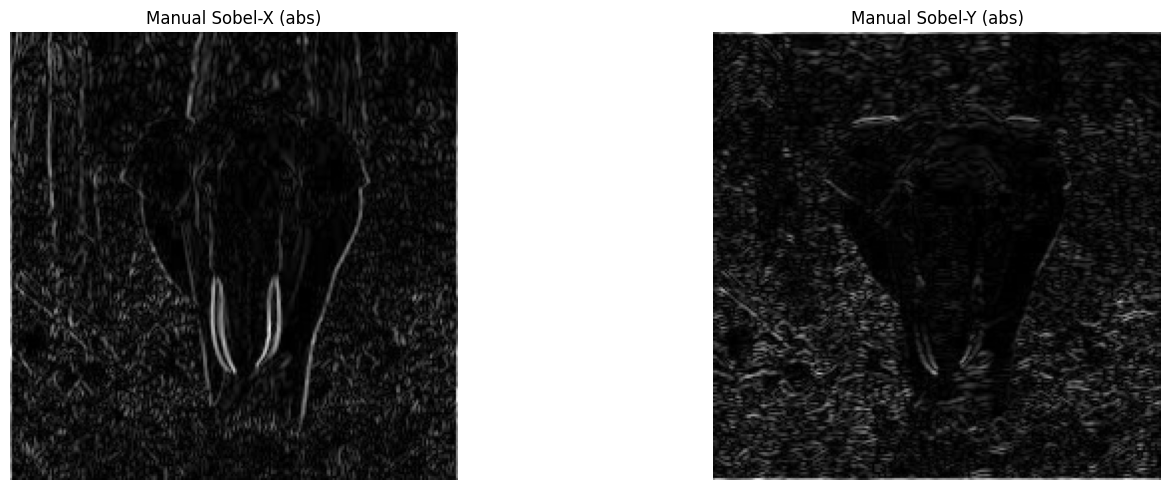

In [7]:
sobel_x = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]], dtype=np.float32)

sobel_y = np.array([[-1,-2,-1],
                    [ 0, 0, 0],
                    [ 1, 2, 1]], dtype=np.float32)

Gx_manual = manual_convolution(gray, sobel_x)
Gy_manual = manual_convolution(gray, sobel_y)

show_row(
    [normalize_0_255(np.abs(Gx_manual)), normalize_0_255(np.abs(Gy_manual))],
    ["Manual Sobel-X (abs)", "Manual Sobel-Y (abs)"]
)


# 2. Gradient Magnitude and Orientation
Compute magnitude and orientation from Sobel outputs.

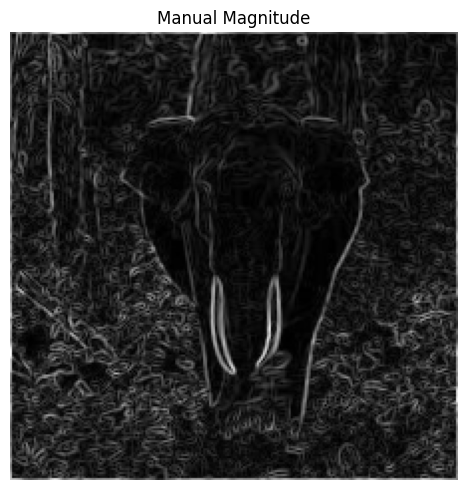

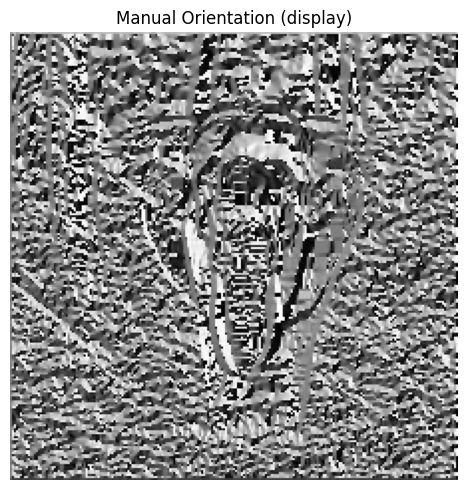

In [8]:
mag_manual = np.sqrt(Gx_manual**2 + Gy_manual**2).astype(np.float32)
theta_manual = np.arctan2(Gy_manual, Gx_manual).astype(np.float32)

show_row([normalize_0_255(mag_manual)], ["Manual Magnitude"])
show_row([normalize_0_255(theta_manual)], ["Manual Orientation (display)"])


# 3. Thresholding
Threshold the magnitude to get a binary edge map.

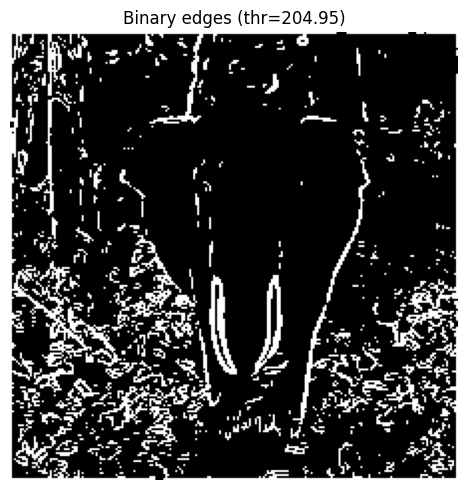

In [9]:
thr = float(np.percentile(mag_manual, 85))  # simple robust threshold
edges_manual = (mag_manual >= thr).astype(np.uint8) * 255

show_row([edges_manual], [f"Binary edges (thr={thr:.2f})"])


# 4. Compare with OpenCV Sobel
We compute Sobel-X and Sobel-Y using OpenCV (cv2.Sobel) with CV_32F so negative gradients are preserved.

We compare:
- Visual outputs (manual vs OpenCV)
- MAE / MSE for Sobel-X, Sobel-Y, and magnitude


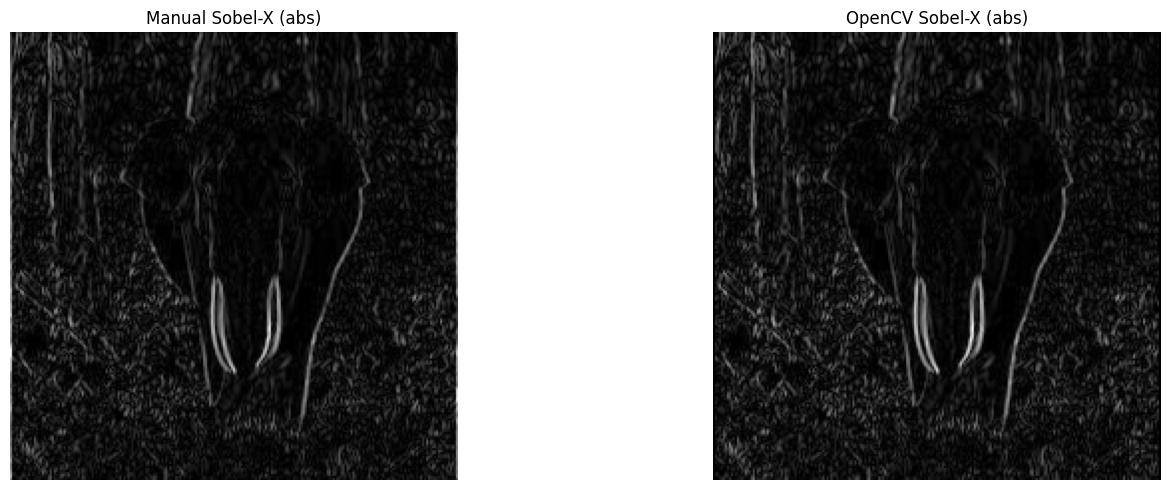

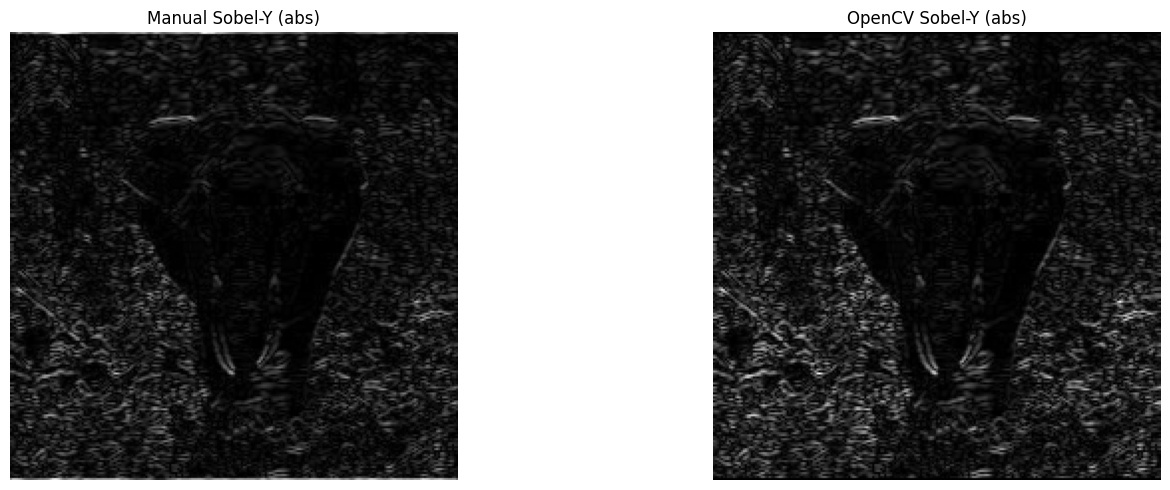

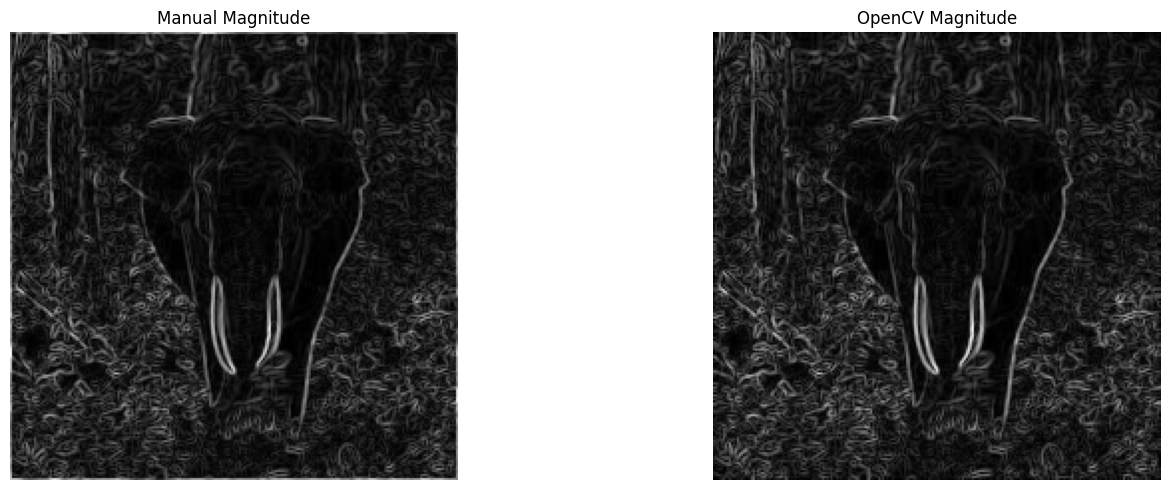

Sobel-X MAE: 4.4838714599609375  | MSE: 2327.64892578125
Sobel-Y MAE: 4.527170181274414  | MSE: 2325.018310546875
Mag     MAE: 7.314540863037109  | MSE: 3456.765869140625


In [10]:
Gx_cv = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
Gy_cv = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)
mag_cv = np.sqrt(Gx_cv**2 + Gy_cv**2).astype(np.float32)

show_row(
    [normalize_0_255(np.abs(Gx_manual)), normalize_0_255(np.abs(Gx_cv))],
    ["Manual Sobel-X (abs)", "OpenCV Sobel-X (abs)"]
)

show_row(
    [normalize_0_255(np.abs(Gy_manual)), normalize_0_255(np.abs(Gy_cv))],
    ["Manual Sobel-Y (abs)", "OpenCV Sobel-Y (abs)"]
)

show_row(
    [normalize_0_255(mag_manual), normalize_0_255(mag_cv)],
    ["Manual Magnitude", "OpenCV Magnitude"]
)

print("Sobel-X MAE:", mae(Gx_manual, Gx_cv), " | MSE:", mse(Gx_manual, Gx_cv))
print("Sobel-Y MAE:", mae(Gy_manual, Gy_cv), " | MSE:", mse(Gy_manual, Gy_cv))
print("Mag     MAE:", mae(mag_manual, mag_cv), " | MSE:", mse(mag_manual, mag_cv))


# 5. Differences (Manual vs OpenCV)

The MAE and MSE values indicate the existence of numerical differences between the manual and OpenCV implementations.
However, a visual comparison shows that both methods detect the same edges, contours, and image structures, and the resulting images appear almost identical.
The numerical differences mainly originate from localized regions near the image borders and from the accumulation of small floating-point variations across the image.
Overall, the manual Sobel implementation produces results that are visually equivalent to those obtained using OpenCV.


